In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

from functions import *

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.last_fit = []
        self.y = []
        self.x = []
        self.max_keep = 5
        
        self.filled = False
        self.iterator = 0
        self.past_coefs = []
        
    # Update the stored lane values
    def update_lane(self, fit, y, x):
        self.last_fit = fit
        self.y = y
        self.x = x
        
    # Retrieve the stored lane values
    def get_lane(self):
        return self.last_fit, self.y, self.x
    
    # Cover all iterations for smoothing
    def smooth(self, new_coefs):
        # Check if enough lanes have been found
        if self.filled == False:
            # Add the new found coefficients onto the list
            self.past_coefs.append(new_coefs)
            
            # Increment the counter
            self.iterator += 1
            
            ## Smooth over however may sets of coefficients have been found so far
            out = self.get_coefs()
            
            # Check if we have sufficiently populated the list
            if self.iterator == self.max_keep:
                self.filled = True
                self.iterator = 0
                print('filled')
                
        # After the list of coefficients has been sufficiently populated
        else:
            # Change the current iterator's coefficients
            self.past_coefs[self.iterator] = new_coefs
            # Smooth of the past self.max_keep coefficients
            self.iterator += 1
            out = self.get_coefs()
            
            if self.iterator == self.max_keep:
                self.iterator = 0
            
        return out
    
    # Support function for smooth()
    def get_coefs(self):
        temp = np.copy(self.past_coefs)
        first = np.median(temp[:,0])
        second = np.median(temp[:,1])
        third = np.median(temp[:,2])
        out = np.array((first,second,third))
            
        return np.ndarray.flatten(out)

In [3]:
def pipeline(img):
    global left, right
    # undistort the image
    undist = undistort(img)
    
    # Extract the binary image
    combined = binary_extraction(undist)
     
    # Warp the image
    warped = warp(combined)
     
    # Mask it
    out = apply_mask(warped)
     
    # Generate a binary output
    binary_warped = np.array(out)
      
    # Find lane indices
    left_lane_inds, right_lane_inds = get_new_indices(binary_warped)
    
    # Where any lane pixels found?
    if (np.count_nonzero(left_lane_inds) != 0) & (np.count_nonzero(right_lane_inds) != 0):
        # Find lane fits
        left_fit, right_fit, lefty, leftx, righty, rightx = get_lane_fits(binary_warped, left_lane_inds, right_lane_inds)
        left.update_lane(left_fit, lefty, leftx)
        right.update_lane(right_fit, righty, rightx)
    else:
        # Use old fits
        left_fit, lefty, leftx = left.get_lane()
        right_fit, righty, rightx = right.get_lane()
    
    # Is this the first frame annotated
    if len(left.past_coefs) != 0:
        l_check = np.linalg.norm(np.subtract(left_fit,left.get_coefs())) < 50
        r_check = np.linalg.norm(np.subtract(right_fit,right.get_coefs())) < 50
    else:
        l_check = True
        r_check = True
    
    # If the current fit is good
    if l_check:
        # Smooth out the current fit
        smoothed_left_fit = left.smooth(left_fit)
    else:
        smoothed_left_fit = left.get_coefs()
        
    if r_check:
        # Smooth out the current fit
        smoothed_right_fit = right.smooth(right_fit)
    else:
        smoothed_right_fit = right.get_coefs()
     
    # Fit the lane pixels
    ploty, left_fitx, right_fitx = identify_lanes(binary_warped, smoothed_left_fit, smoothed_right_fit)
     
    # Find the curvature
    left_curverad, right_curverad = curvature(ploty, lefty, righty, leftx, rightx)
     
    # Draw the found lanes
    warp_zero = draw_lanes(img, ploty, left_fitx, right_fitx)
     
    # Annotate original frame with lanes
    lane = unwarp_lanes(img, warp_zero)
     
    # Annotate found lanes with text
    result = write_text(lane, left_fitx, right_fitx, left_curverad, right_curverad)
    
    return result

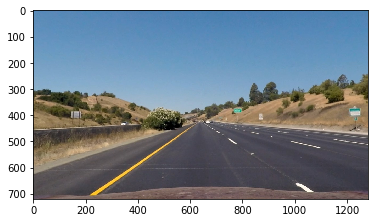

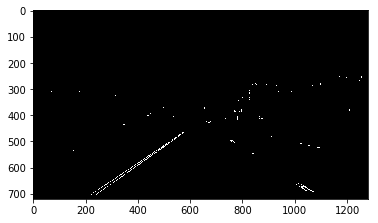

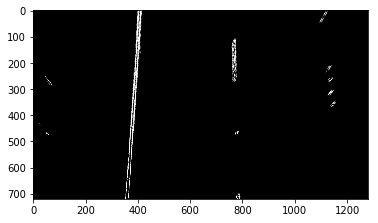

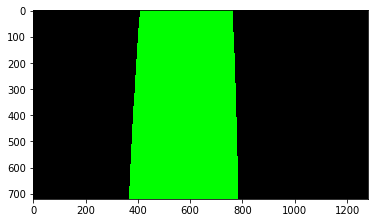

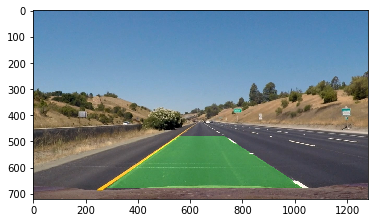

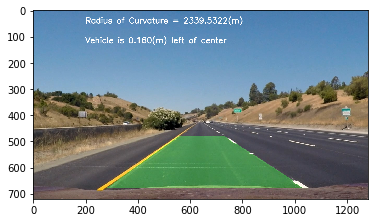

In [4]:
left = Line()
right = Line()

fpaths = glob.glob('./test_images/*.jpg')
img = mpimg.imread(fpaths[0])

undist = undistort(img)
plt.figure()
plt.imshow(undist)
plt.savefig('./turn_in/output_images/undist.jpg')

# Extract the binary image
combined = binary_extraction(undist)
plt.figure()
plt.imshow(combined,cmap='gray')
plt.savefig('./turn_in/output_images/combined.jpg')
     
# Warp the image
warped = warp(combined)
plt.figure()
plt.imshow(warped,cmap='gray')
plt.savefig('./turn_in/output_images/warped.jpg')

out = apply_mask(warped)
binary_warped = np.array(out)
left_lane_inds, right_lane_inds = get_new_indices(binary_warped)
if (np.count_nonzero(left_lane_inds) != 0) & (np.count_nonzero(right_lane_inds) != 0):
    left_fit, right_fit, lefty, leftx, righty, rightx = get_lane_fits(binary_warped, left_lane_inds, right_lane_inds)
    left.update_lane(left_fit, lefty, leftx)
    right.update_lane(right_fit, righty, rightx)
else:
    left_fit, lefty, leftx = left.get_lane()
    right_fit, righty, rightx = right.get_lane()
if len(left.past_coefs) != 0:
    l_check = np.linalg.norm(np.subtract(left_fit,left.get_coefs())) < 50
    r_check = np.linalg.norm(np.subtract(right_fit,right.get_coefs())) < 50
else:
    l_check = True
    r_check = True
if l_check:
    smoothed_left_fit = left.smooth(left_fit)
else:
    smoothed_left_fit = left.get_coefs()
if r_check:
    smoothed_right_fit = right.smooth(right_fit)
else:
    smoothed_right_fit = right.get_coefs()
    
ploty, left_fitx, right_fitx = identify_lanes(binary_warped, smoothed_left_fit, smoothed_right_fit)
left_curverad, right_curverad = curvature(ploty, lefty, righty, leftx, rightx)
warp_zero = draw_lanes(img, ploty, left_fitx, right_fitx)
plt.figure()
plt.imshow(warp_zero,cmap='gray')
plt.savefig('./turn_in/output_images/warp_zero.jpg')
     
# Annotate original frame with lanes
lane = unwarp_lanes(img, warp_zero)
plt.figure()
plt.imshow(lane)
plt.savefig('./turn_in/output_images/lane.jpg')
     
# Annotate found lanes with text
result = write_text(lane, left_fitx, right_fitx, left_curverad, right_curverad)
plt.figure()
plt.imshow(result)
plt.savefig('./turn_in/output_images/result.jpg')

In [5]:
left = Line()
right = Line()

project_output = './turn_in/annotated_project.mp4'
project_clip = VideoFileClip("project_video.mp4")
project_out = project_clip.fl_image(lambda x: pipeline(x)) #NOTE: this function expects color images!!
%time project_out.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./turn_in/annotated_project.mp4
[MoviePy] Writing video ./turn_in/annotated_project.mp4


  0%|          | 5/1261 [00:00<02:11,  9.55it/s]

filled
filled


100%|█████████▉| 1260/1261 [02:26<00:00,  8.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./turn_in/annotated_project.mp4 

CPU times: user 11min 35s, sys: 2.84 s, total: 11min 38s
Wall time: 2min 27s
